# Customer Churn Prediction

## Introduction
This notebook focus the [Telco Customer Churn](https://www.kaggle.com/datasets/blastchar/telco-customer-churn) dataset to predict which customers are likely to leave the telecommunications service. We will explore the data, perform necessary preprocessing, and build classification models to predict customer churn. The analysis will compare the performance of different classifier models and identify the key factors that contribute to customer attrition.

## 1. Import Libraries

In [2]:
!pip install numpy pandas scikit-learn imbalanced-learn matplotlib seaborn xgboost -q

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, StackingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay,classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

## 2. Load Data

In [12]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [13]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 3. EDA

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


We need to change data type of `TotalCharges` to float.

In [15]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [17]:
df.isna().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


We can see 11 missing values. we can remove it beacuse it is small consider with entire data set.

In [18]:
df = df.dropna()
df.isna().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


Let's remove `customerID` beacuse it is not need to training process.

In [19]:
df = df.drop("customerID", axis=1)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [20]:
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Identify categorical columns (all other columns except numerical ones)
categorical_cols = [col for col in df.columns if col not in numerical_cols]

print("Numerical Columns:", numerical_cols)
print(f"Total: {len(numerical_cols)}\n")

print("Categorical Columns:", categorical_cols)
print(f"Total: {len(categorical_cols)}")

Numerical Columns: ['tenure', 'MonthlyCharges', 'TotalCharges']
Total: 3

Categorical Columns: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']
Total: 17


## 4. Visualize Data

### 4.1 Visualize numerical data

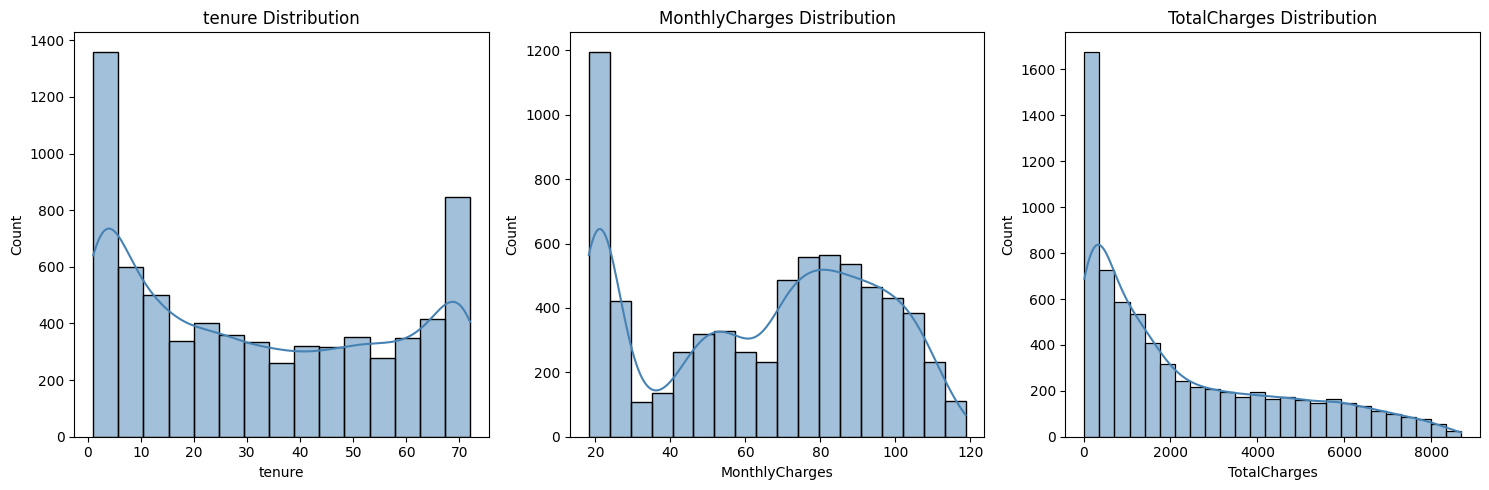

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for idx, col in enumerate(numerical_cols):
    sns.histplot(df[col], kde=True, ax=axes[idx], color='steelblue')
    axes[idx].set_title(f'{col} Distribution')
plt.tight_layout()
plt.show()

### 4.2 Visualize catagorical data

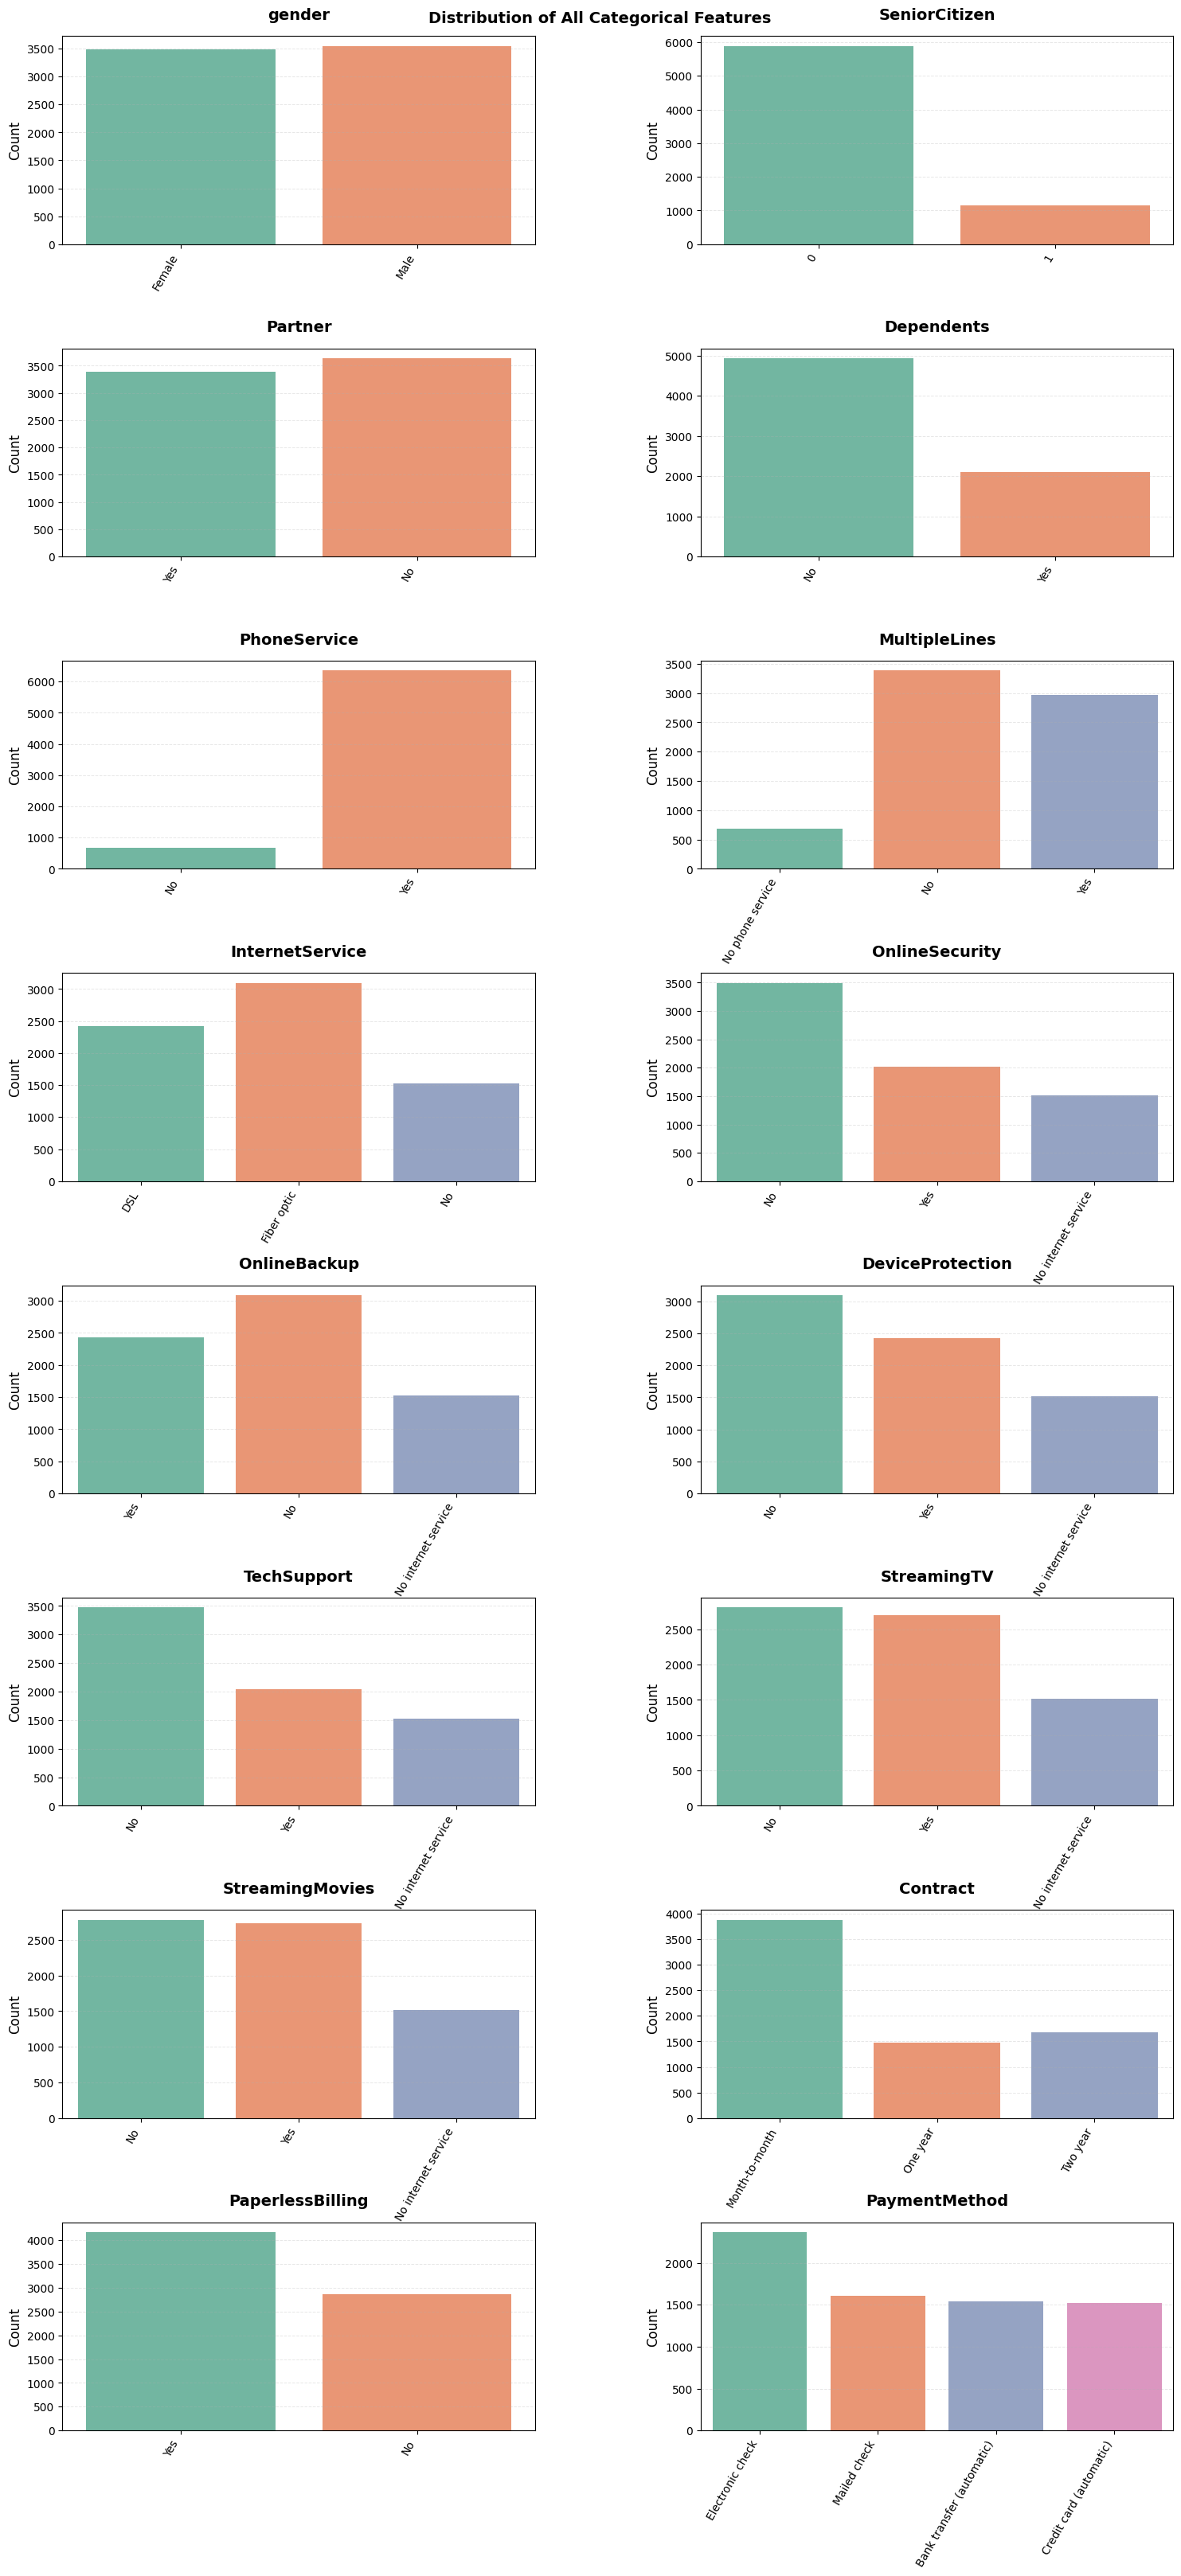

In [22]:
# Plot all categorical features (16 features)
categorical_features = [col for col in categorical_cols if col not in ['Churn']]

# Plot all categorical features (2 columns x 8 rows)
fig, axes = plt.subplots(8, 2, figsize=(18, 32))
fig.suptitle('Distribution of All Categorical Features', fontsize=14, fontweight='bold')
axes = axes.ravel()

for idx, col in enumerate(categorical_features):
    if idx < len(axes):
        # Create the plot
        sns.countplot(data=df, x=col, hue=col, ax=axes[idx], palette='Set2', legend=False)

        # Set title and labels
        axes[idx].set_title(f'{col}', fontsize=14, fontweight='bold', pad=15)
        axes[idx].set_xlabel('')
        axes[idx].set_ylabel('Count', fontsize=12)

        # Rotate x-axis labels and align properly
        axes[idx].tick_params(axis='x', rotation=60, labelsize=10)
        axes[idx].tick_params(axis='y', labelsize=10)

        # Set horizontal alignment for x labels
        for label in axes[idx].get_xticklabels():
            label.set_ha('right')

        # Add grid
        axes[idx].grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.7)

# Hide unused subplots if any
for idx in range(len(categorical_features), len(axes)):
    axes[idx].axis('off')

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.35, top=0.97, bottom=0.03)
plt.show()

### 4.3 Visualize output

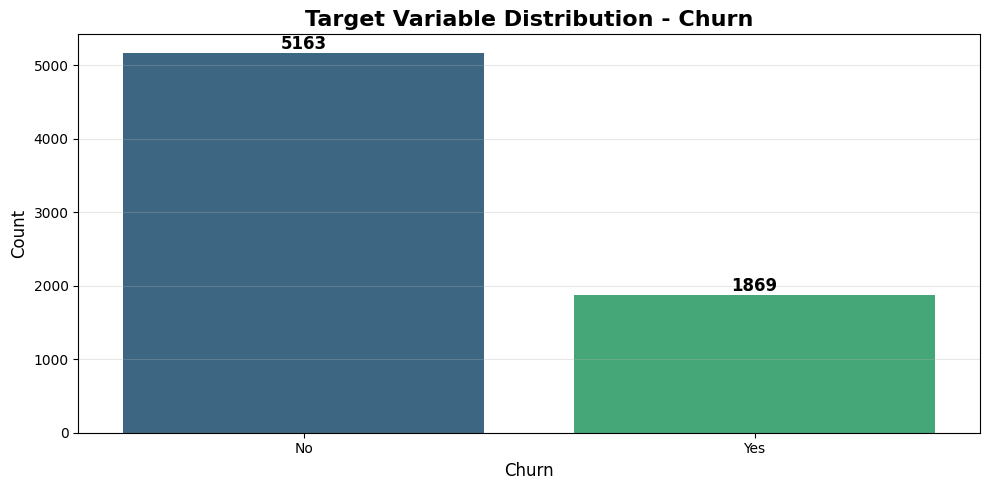

In [23]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(data=df, x='Churn', hue='Churn', ax=ax, palette='viridis', legend=False)
ax.set_title('Target Variable Distribution - Churn', fontsize=16, fontweight='bold')
ax.set_xlabel('Churn', fontsize=12)
ax.set_ylabel('Count', fontsize=12)

# Add count labels
total = len(df)
for container in ax.containers:
    ax.bar_label(container, fontsize=12, fontweight='bold')

ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

We can see class imbalance in here.

## 5. Data Preprocessing

In [24]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

Encode target variable (Yes/No to 1/0)

In [25]:
le_target = LabelEncoder()
y = le_target.fit_transform(y)

print(f"Target encoding: {dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))}")
print(f"Class distribution: {np.bincount(y)}")

Target encoding: {'No': np.int64(0), 'Yes': np.int64(1)}
Class distribution: [5163 1869]


Split data into train and test datasets.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

In [27]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4922, 19), (4922,), (2110, 19), (2110,))

### 5.1 Create Pipelines

In [28]:
binary_features = []
multi_category_features = []

for col in categorical_cols:
    if col in ['Churn']:
        continue
    if df[col].nunique() == 2:
        binary_features.append(col)
    else:
        multi_category_features.append(col)

print(f"\nBinary features ({len(binary_features)}): {binary_features}")
print(f"\nMulti-category features ({len(multi_category_features)}): {multi_category_features}")
print(f"\nNumerical features ({len(numerical_cols)}): {numerical_cols}")


Binary features (6): ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']

Multi-category features (10): ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']

Numerical features (3): ['tenure', 'MonthlyCharges', 'TotalCharges']


### 5.2 Create preprocess

In [29]:
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', 'passthrough', numerical_cols),
        ('binary', OrdinalEncoder(), binary_features),
        ('catagorical', OneHotEncoder(drop='first', handle_unknown='ignore'), multi_category_features)
    ],
    remainder='drop'
)

## 6. Model Training

### Experiment with `RandomForestClassifier`

In [30]:
RF_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(
        random_state=42
    ))
])

In [31]:
RF_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('binary', OrdinalEncoder(),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'PaperlessBilling']),
                                                 ('catagorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaymentMethod'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [32]:
# Predict on test data
y_pred_rf = RF_pipeline.predict(X_test)

# Evaluation metrics
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.7758293838862559

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.85      1549
           1       0.60      0.48      0.53       561

    accuracy                           0.78      2110
   macro avg       0.71      0.68      0.69      2110
weighted avg       0.76      0.78      0.77      2110



### Hyperparameter tuning for `RandomForestClassifier`

In [33]:
# Define parameter grid
param_grid_RF = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10, 15],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__max_features': ['sqrt', 'log2']
}

# Grid search setup
grid_search_RF = GridSearchCV(
    estimator=RF_pipeline,
    param_grid=param_grid_RF,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit the model
grid_search_RF.fit(X_train, y_train)

# Display best parameters and accuracy
print("Best Parameters:", grid_search_RF.best_params_)
print("Best Cross-Validation Accuracy:", grid_search_RF.best_score_)

# Get best model
best_rf_model = grid_search_RF.best_estimator_

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Parameters: {'classifier__max_depth': 15, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best Cross-Validation Accuracy: 0.8017045426395764


In [34]:
# Evaluate the best model on the test set
y_pred_best_rf = best_rf_model.predict(X_test)

print("Best Random Forest Accuracy on Test Set:", accuracy_score(y_test, y_pred_best_rf))
print("\nClassification Report for Best Random Forest Model:\n", classification_report(y_test, y_pred_best_rf))

Best Random Forest Accuracy on Test Set: 0.7886255924170616

Classification Report for Best Random Forest Model:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86      1549
           1       0.62      0.54      0.58       561

    accuracy                           0.79      2110
   macro avg       0.73      0.71      0.72      2110
weighted avg       0.78      0.79      0.78      2110



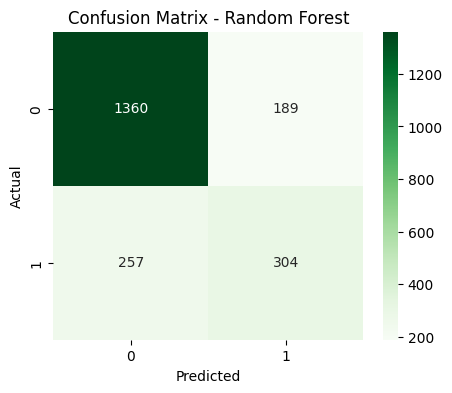

In [35]:
# Confusion matrix visualization
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_best_rf), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [36]:
with open('best_rf_mode.pkl', 'wb') as file:
    pickle.dump(best_rf_model, file)

### Experiment with `XGBClassifier`

In [37]:
XG_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(
        random_state=42
    ))
])

In [38]:
XG_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('binary', OrdinalEncoder(),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'PaperlessBilling']),
                                                 ('catagorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['MultipleLines',
                                                   'InternetService',
                                                   '...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [39]:
# Predict on test data
y_pred_xg = XG_pipeline.predict(X_test)

# Evaluation metrics
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

XGBoost Accuracy: 0.7758293838862559

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.85      1549
           1       0.60      0.48      0.53       561

    accuracy                           0.78      2110
   macro avg       0.71      0.68      0.69      2110
weighted avg       0.76      0.78      0.77      2110



### Hyperparameter tuning for `XGBClassifier`

In [40]:
param_grid_XG = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [4, 6, 8],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 1],
    'classifier__colsample_bytree': [0.8, 1]
}

grid_search_XG = GridSearchCV(
    estimator=XG_pipeline,
    param_grid=param_grid_XG,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1,
    refit=True
)

grid_search_XG.fit(X_train, y_train)

print("Best Parameters:", grid_search_XG.best_params_)
print("Best Accuracy:", grid_search_XG.best_score_)

best_XG_model = grid_search_XG.best_estimator_

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Parameters: {'classifier__colsample_bytree': 1, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 4, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}
Best Accuracy: 0.7980478639338496


In [41]:
# Evaluate the best model on the test set
y_pred_best_XG = best_XG_model.predict(X_test)

print("Best XGBoost Accuracy on Test Set:", accuracy_score(y_test, y_pred_best_XG))
print("\nClassification Report for Best XGBoost Model:\n", classification_report(y_test, y_pred_best_XG))

Best XGBoost Accuracy on Test Set: 0.7900473933649289

Classification Report for Best XGBoost Model:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86      1549
           1       0.61      0.57      0.59       561

    accuracy                           0.79      2110
   macro avg       0.73      0.72      0.72      2110
weighted avg       0.79      0.79      0.79      2110



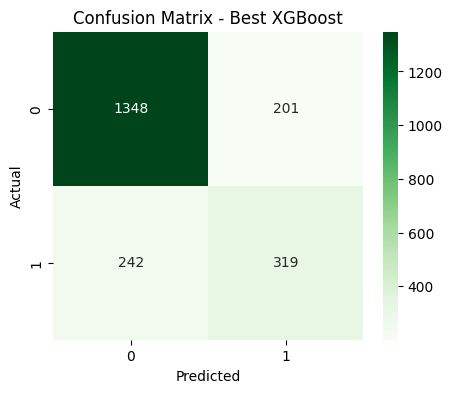

In [42]:
# Confusion matrix visualization for the best XGBoost model
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_best_XG), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Best XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [43]:
with open('best_XG_mode.pkl', 'wb') as file:
    pickle.dump(best_XG_model, file)

### Experiment with `BaggingClassifier`

In [44]:
Bagging_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', BaggingClassifier(
        random_state=42
    ))
])

In [45]:
Bagging_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('binary', OrdinalEncoder(),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'PaperlessBilling']),
                                                 ('catagorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaymentMethod'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', BaggingClassifier(random_state=42))])

In [46]:
# Predict on test data
y_pred_Bagging = Bagging_pipeline.predict(X_test)

# Evaluation metrics
print("Bagging Accuracy:", accuracy_score(y_test, y_pred_Bagging))
print("\nClassification Report:\n", classification_report(y_test, y_pred_Bagging))

Bagging Accuracy: 0.7734597156398104

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.85      1549
           1       0.59      0.49      0.54       561

    accuracy                           0.77      2110
   macro avg       0.71      0.68      0.69      2110
weighted avg       0.76      0.77      0.77      2110



### Hyperparameter tuning for `BaggingClassifier`

In [47]:
param_grid_Bagging = {
    'classifier__n_estimators': [10, 50, 100],
    'classifier__max_samples': [0.5, 0.8, 1.0],
    'classifier__max_features': [0.5, 0.8, 1.0],
    'classifier__estimator': [None, DecisionTreeClassifier(max_depth=5)] # Experiment with base estimator
}

grid_search_Bagging = GridSearchCV(
    estimator=Bagging_pipeline,
    param_grid=param_grid_Bagging,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1,
    refit=True
)

grid_search_Bagging.fit(X_train, y_train)

print("Best Parameters:", grid_search_Bagging.best_params_)
print("Best Accuracy:", grid_search_Bagging.best_score_)

best_Bagging_model = grid_search_Bagging.best_estimator_

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best Parameters: {'classifier__estimator': None, 'classifier__max_features': 0.5, 'classifier__max_samples': 0.8, 'classifier__n_estimators': 100}
Best Accuracy: 0.7986570007381976


In [48]:
# Evaluate the best Bagging model on the test set
y_pred_best_Bagging = best_Bagging_model.predict(X_test)

print("Best Bagging Accuracy on Test Set:", accuracy_score(y_test, y_pred_best_Bagging))
print("\nClassification Report for Best Bagging Model:\n", classification_report(y_test, y_pred_best_Bagging))

Best Bagging Accuracy on Test Set: 0.7867298578199052

Classification Report for Best Bagging Model:
               precision    recall  f1-score   support

           0       0.83      0.88      0.86      1549
           1       0.62      0.52      0.56       561

    accuracy                           0.79      2110
   macro avg       0.73      0.70      0.71      2110
weighted avg       0.78      0.79      0.78      2110



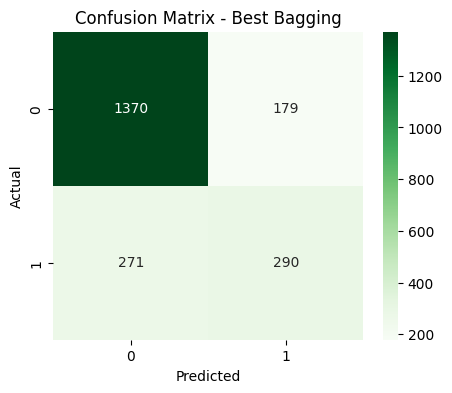

In [49]:
# Confusion matrix visualization for the best Bagging model
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_best_Bagging), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Best Bagging")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [50]:
with open('best_Bagging_mode.pkl', 'wb') as file:
    pickle.dump(best_Bagging_model, file)

### Experiment with `Ada BosstingClassifier`

In [51]:
AdaBoosting_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', AdaBoostClassifier(
        random_state=42
    ))
])

In [52]:
AdaBoosting_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('binary', OrdinalEncoder(),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'PaperlessBilling']),
                                                 ('catagorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaymentMethod'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', AdaBoostClassifier(random_state=42))])

In [53]:
# Predict on test data
y_pred_AdaBoosting = AdaBoosting_pipeline.predict(X_test)

# Evaluation metrics
print("Ada Boosting Accuracy:", accuracy_score(y_test, y_pred_AdaBoosting))
print("\nClassification Report:\n", classification_report(y_test, y_pred_AdaBoosting))

Ada Boosting Accuracy: 0.7729857819905214

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.82      0.84      1549
           1       0.56      0.64      0.60       561

    accuracy                           0.77      2110
   macro avg       0.71      0.73      0.72      2110
weighted avg       0.78      0.77      0.78      2110



### Hyperparameter tuning for `Ada BosstingClassifier`

In [54]:
param_grid_AdaBoosting = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 1.0],
    'classifier__estimator': [None, DecisionTreeClassifier(max_depth=1, random_state=42)] # Experiment with base estimator
}

grid_search_AdaBoosting = GridSearchCV(
    estimator=AdaBoosting_pipeline,
    param_grid=param_grid_AdaBoosting,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1,
    refit=True
)

grid_search_AdaBoosting.fit(X_train, y_train)

print("Best Parameters:", grid_search_AdaBoosting.best_params_)
print("Best Accuracy:", grid_search_AdaBoosting.best_score_)

best_AdaBoosting_model = grid_search_AdaBoosting.best_estimator_

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Parameters: {'classifier__estimator': None, 'classifier__learning_rate': 1.0, 'classifier__n_estimators': 200}
Best Accuracy: 0.8023142987371373


In [55]:
# Evaluate the best AdaBoosting model on the test set
y_pred_best_AdaBoosting = best_AdaBoosting_model.predict(X_test)

print("Best Ada Boosting Accuracy on Test Set:", accuracy_score(y_test, y_pred_best_AdaBoosting))
print("\nClassification Report for Best Ada Boosting Model:\n", classification_report(y_test, y_pred_best_AdaBoosting))

Best Ada Boosting Accuracy on Test Set: 0.7867298578199052

Classification Report for Best Ada Boosting Model:
               precision    recall  f1-score   support

           0       0.86      0.85      0.85      1549
           1       0.60      0.61      0.60       561

    accuracy                           0.79      2110
   macro avg       0.73      0.73      0.73      2110
weighted avg       0.79      0.79      0.79      2110



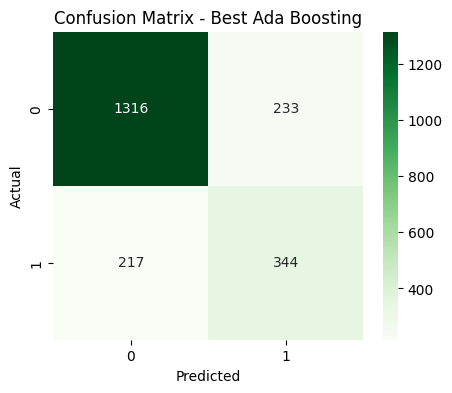

In [56]:
# Confusion matrix visualization for the best AdaBoosting model
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_best_AdaBoosting), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Best Ada Boosting")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [57]:
with open('best_AdaBoosting_mode.pkl', 'wb') as file:
    pickle.dump(best_AdaBoosting_model, file)

### Experiment with `Gradient Bossting Classifier`

In [58]:
GB_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', GradientBoostingClassifier(
        random_state=42
    ))
])

In [59]:
GB_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('binary', OrdinalEncoder(),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'PaperlessBilling']),
                                                 ('catagorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaymentMethod'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', GradientBoostingClassifier(random_state=42))])

In [60]:
# Predict on test data
y_pred_GB = GB_pipeline.predict(X_test)

# Evaluation metrics
print(" Gradient Bossting Accuracy:", accuracy_score(y_test, y_pred_GB))
print("\nClassification Report:\n", classification_report(y_test, y_pred_GB))

 Gradient Bossting Accuracy: 0.7924170616113744

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86      1549
           1       0.61      0.59      0.60       561

    accuracy                           0.79      2110
   macro avg       0.73      0.73      0.73      2110
weighted avg       0.79      0.79      0.79      2110



### Hyperparameter tuning for `Gradient Bossting Classifier`

In [61]:
param_grid_GB = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 4, 5],
    'classifier__subsample': [0.8, 1.0]
}

grid_search_GB = GridSearchCV(
    estimator=GB_pipeline,
    param_grid=param_grid_GB,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1,
    refit=True
)

grid_search_GB.fit(X_train, y_train)

print("Best Parameters:", grid_search_GB.best_params_)
print("Best Accuracy:", grid_search_GB.best_score_)

best_GB_model = grid_search_GB.best_estimator_

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 1.0}
Best Accuracy: 0.7996730131835138


In [63]:
# Evaluate the best Gradient Boosting model on the test set
y_pred_best_GB = best_GB_model.predict(X_test)

print("Best Gradient Boosting Accuracy on Test Set:", accuracy_score(y_test, y_pred_best_GB))
print("\nClassification Report for Best Gradient Boosting Model:\n", classification_report(y_test, y_pred_best_GB))

Best Gradient Boosting Accuracy on Test Set: 0.7924170616113744

Classification Report for Best Gradient Boosting Model:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86      1549
           1       0.61      0.59      0.60       561

    accuracy                           0.79      2110
   macro avg       0.73      0.73      0.73      2110
weighted avg       0.79      0.79      0.79      2110



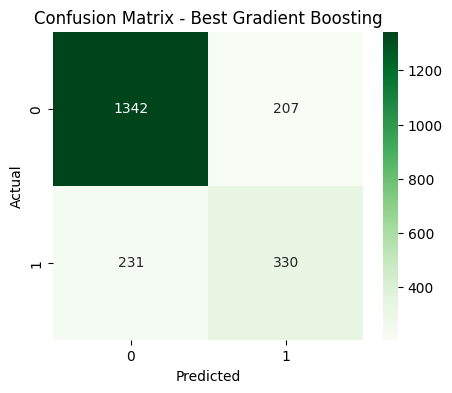

In [64]:
# Confusion matrix visualization for the best Gradient Boosting model
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_best_GB), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Best Gradient Boosting")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [65]:
with open('best_GB_mode.pkl', 'wb') as file:
    pickle.dump(best_GB_model, file)

### Experiment with `Stacking Classifier`

In [66]:
estimators = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('xgb', XGBClassifier(random_state=42)),
    ('bag', BaggingClassifier(random_state=42)),
    ('ada', AdaBoostClassifier(random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42))
]

Stacking_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', StackingClassifier(estimators=estimators, final_estimator=LogisticRegression()))
])

In [69]:
Stacking_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('binary', OrdinalEncoder(),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'PaperlessBilling']),
                                                 ('catagorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['MultipleLines',
                                                   'InternetService',
                                                   '...
                                                               max_delta_step=None,
                                                               max_depth=None,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=None,
                                                               n_jobs=None,
                                                               num_parallel_tree=None, ...)),
                                                ('bag',
                                                 BaggingClassifier(random_state=42)),
                                                ('ada',
                                                 AdaBoostClassifier(random_state=42)),
                                                ('gb',
                                                 GradientBoostingClassifier(random_state=42))],
                                    final_estimator=LogisticRegression()))])

In [72]:
# Predict on test data
y_pred_stacking = Stacking_pipeline.predict(X_test)

# Evaluation metrics
print("Stacking Classifier Accuracy:", accuracy_score(y_test, y_pred_stacking))
print("\nClassification Report:\n", classification_report(y_test, y_pred_stacking))

Stacking Classifier Accuracy: 0.7867298578199052

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.86      0.86      1549
           1       0.60      0.58      0.59       561

    accuracy                           0.79      2110
   macro avg       0.73      0.72      0.72      2110
weighted avg       0.78      0.79      0.79      2110



### Hyperparameter tuning for `Stacking Classifier`

In [73]:
param_grid_Stacking = {
    'classifier__final_estimator__C': [0.1, 1, 10],
    'classifier__passthrough': [True, False]
}

# Grid search setup
grid_search_Stacking = GridSearchCV(
    estimator=Stacking_pipeline,
    param_grid=param_grid_Stacking,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1,
    refit=True
)

In [74]:
grid_search_Stacking.fit(X_train, y_train)

print("Best Parameters:", grid_search_Stacking.best_params_)
print("Best Accuracy:", grid_search_Stacking.best_score_)

best_Stacking_model = grid_search_Stacking.best_estimator_

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters: {'classifier__final_estimator__C': 1, 'classifier__passthrough': False}
Best Accuracy: 0.8006890256288304


In [77]:
# Evaluate the best Stacking model on the test set
y_pred_best_Stacking = best_Stacking_model.predict(X_test)

print("Best Stacking Classifier Accuracy on Test Set:", accuracy_score(y_test, y_pred_best_Stacking))
print("\nClassification Report for Best Stacking Classifier Model:\n", classification_report(y_test, y_pred_best_Stacking))

Best Stacking Classifier Accuracy on Test Set: 0.7867298578199052

Classification Report for Best Stacking Classifier Model:
               precision    recall  f1-score   support

           0       0.85      0.86      0.86      1549
           1       0.60      0.58      0.59       561

    accuracy                           0.79      2110
   macro avg       0.73      0.72      0.72      2110
weighted avg       0.78      0.79      0.79      2110



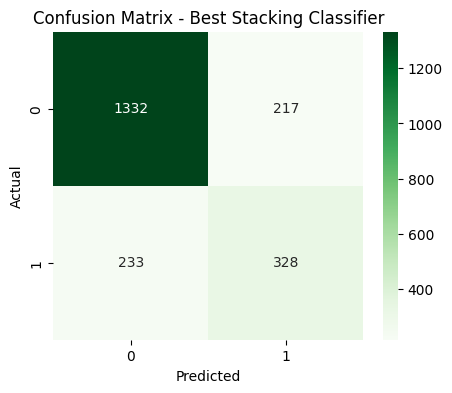

In [78]:
# Confusion matrix visualization for the best Stacking Classifier
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_best_Stacking), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Best Stacking Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [81]:
with open('best_Stacking_model.pkl', 'wb') as file:
    pickle.dump(best_Stacking_model, file)

## 7. Model Comparison

Let's compare the performance metrics of all the trained models on the test set.

In [80]:
models = {
    "Random Forest": best_rf_model,
    "XGBoost": best_XG_model,
    "Bagging": best_Bagging_model,
    "Ada Boosting": best_AdaBoosting_model,
    "Gradient Boosting": best_GB_model,
    "Stacking Classifier": best_Stacking_model
}

results = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    }

results_df = pd.DataFrame(results).T
display(results_df.sort_values(by="Accuracy", ascending=False))

,Accuracy,Precision,Recall,F1-Score
Gradient Boosting,0.792417,0.614525,0.588235,0.601093
XGBoost,0.790047,0.613462,0.568627,0.590194
Random Forest,0.788626,0.616633,0.541889,0.576850
Bagging,0.786730,0.618337,0.516934,0.563107
Ada Boosting,0.786730,0.596187,0.613191,0.604569
Stacking Classifier,0.786730,0.601835,0.584670,0.593128


1. The **Gradient Boosting** model achieved the highest accuracy of **0.792417**, showing the best overall performance.  
2. The **XGBoost** model performed closely behind, with good precision but a slightly lower recall.  
3. The **Random Forest** and **Bagging** models showed moderate accuracy but lower recall values, meaning they missed more churn cases.  
4. The **AdaBoost** model had a balanced performance with a slightly better recall than Bagging.  
5. The **Stacking Classifier** achieved the same accuracy as AdaBoost and Bagging but had slightly lower recall, and F1-score compared to AdaBoost.
6. Overall, **Gradient Boosting** proved to be the most effective model for predicting customer churn in this study.
